# Breakout Trading Strategy on Highly Volatile Stocks 
This project presents a comprehensive and data-driven trading strategy that utilizes Bollinger Bands and Bollinger Phases to identify potential breakout opportunities for long positions. In addition, Average True Range (ATR) is incorporated to dynamically set optimal take profit and stop loss targets, enhancing risk management and potential returns.

The strategy's performance is assessed through backtesting on three highly volatile stocks, namely Tesla, Nvidia, and Amazon, all possessing a beta greater than 1. This selection enables the strategy to capitalize on significant price movements.

To provide analysis and facilitate strategy evaluation, data visualization techniques are used to display the strategy's performance and buy/sell signals. Key financial metrics such as Compound Annual Growth Rate (CAGR), Sharpe ratio, and Maximum Drawdown are featured, showing an overview of the strategy's risk-reward profile.


#### The notebook is structured as follows:
1. [Import and Prepare the Data](#importing-data): The stock data for the chosen tickers is imported using Yahoo Finance. 

2. [Strategy Implementation](#strategy-implementation): Contains a function to be called when executing a trade and a second function that implements the strategy on the inputted data.

3. [Strategy Visualisation](#strategy-visualisation): Contains a function to visualise strategy returns and buy/sell signals.

4. [Strategy Metrics](#strategy-metrics): Contains a function that returns the Sharpe Ratio, Cumulative Returns, CAGR and maximum drawdow, making comparisons to the underlying stock.

5. [Strategy Results](#strategy-results): In this section the functions created on all other sections are used on the three chosen stocks and the results are shown.


## Import Libraries

In [7]:
# For data manipulation and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Markdown

# For technical indicators computation
import talib as ta
import yfinance as yf
import datetime as dt

# For filtering warnings
import warnings
warnings.filterwarnings("ignore")

## Importing Data

In [8]:
# Download Stock Data from Yahoo Finance 
tsla = yf.download('TSLA',"2022-01-01")
nvda = yf.download('NVDA',"2022-01-01")
amzn = yf.download('AMZN',"2022-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Strategy Implentation

In [9]:
# Create Function to store a new trade in the trade book
def trade(data, time, entry_time, entry_price):
    exit_price = data.loc[time, 'Close'] 
    # Calculate PnL
    pnl = round(exit_price - entry_price, 2)
    # Calculate trading cost due to fees
    trading_cost = exit_price * 0.0002 * 2
    pnl -= trading_cost
    trades = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])
    return trades.append({
        'Position': 'Long',
        'Entry Time' : entry_time,
        'Entry Price' : entry_price,
        'Exit Time' : time, 
        'Exit Price': exit_price, 
        'PnL' : pnl
    }, ignore_index=True)


# Create the function to backtest the strategy
def performance(stock):
    """
    Function used to backtest the strategy for each stock.
    """
    # Copy the close prices
    data = stock.copy()
    # Create the Bollinger bands
    data['upper'], data['middle'], data['lower'] = ta.BBANDS(data['Close'], timeperiod=20)
    # Create the band's width
    data['bandwidth'] = (data['upper'] - data['lower'])/data['middle']
    # Calculate the rolling width
    data['rolling_bandwidth'] = data['bandwidth'].rolling(21).mean()
    # Compute the condition 1
    data['condition1'] = data['bandwidth'] > data['rolling_bandwidth']
    # Compute the condition 2
    data['condition2'] = data['High'] > data['upper']
    # Compute the signal: First step
    data['long_signal'] = np.where(data['condition1'] & data['condition2'], 1, np.nan)
    # Compute the signal: Second step
    data['long_signal'] = np.where(data['Low'] < data['middle'], 0, data['long_signal'])
    # Fill the NaN values with previous observations
    data['long_signal'] = data['long_signal'].fillna(method = "ffill")
    # Define variables to keep track of current position, take profit and stop loss multiples of ATR 
    current_position = 0
    stop_loss_multiple = 1.5
    take_profit_multiple = 3
    # Calculate the Average True Range(ATR)
    data['ATR'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    # Entry time and price of when we buy the stock
    entry_time = np.nan
    entry_price = np.nan
    
    # Create the trade book where all the trades get stored
    trade_book = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])

    # Create the loop to backtest
    for time in data.index:
        # Condition to go long
        if current_position == 0 and data.loc[time, 'long_signal'] == 1:
            current_position = 1
            entry_time = time
            entry_price = data.loc[time, 'Close']
        elif current_position == 1:
            # Specify the stop loss target as the max between a multiple of the ATR or the middle Bollinger band
            stop_loss = max(entry_price - data.loc[time, 'ATR'] * stop_loss_multiple, data.loc[time, 'middle'])
            # Specify the take profit target
            take_profit = entry_price + data.loc[time, 'ATR'] * take_profit_multiple
            # Condition to exit the Long position
            if data.loc[time, 'Close'] > take_profit or data.loc[time, 'Close'] < stop_loss:
                trade_book = pd.concat([trade_book, trade(data, time, entry_time, entry_price)])
                trade_book = trade_book.reset_index(drop = True)
                current_position = 0
            
    # Create the long_position column
    data['long_position'] = np.nan
    data.loc[data.index.isin(trade_book['Entry Time']), 'long_position'] = 1
    data.loc[data.index.isin(trade_book['Exit Time']), 'long_position'] = 0
    data['long_position'] = data['long_position'].fillna(method = "ffill")
    data = data.dropna()
    # Assign the entry price to the buy signal
    data['buy_signal'] = np.nan
    data.loc[data.index.isin(trade_book['Entry Time']), 'buy_signal'] = trade_book['Entry Price'].values
    # Assign the exit price to the sell signal
    data['sell_signal'] = np.nan
    data.loc[trade_book['Exit Time'], 'sell_signal'] = trade_book['Exit Price'].values
    # Compute the strategy returns
    data['returns'] = data['long_position'].shift(1) * data['Close'].pct_change()
    data['cumulative_returns'] = ((1+data['returns']).cumprod())
    data['cumulative_returns%'] = (data['cumulative_returns']-1)*100
    # Compute the stock's returns for comparison
    data['stock_returns'] = data['Close'].pct_change()
    data['cumulative_stock_returns%'] = ((1+data['stock_returns']).cumprod()-1)*100

    # Return data frames containing all information 
    return data, trade_book


## Strategy Visualisation

In [10]:
def plot(data, name):   
    # Define a new color scheme
    color_close = 'dodgerblue'  # Blue for Close Price
    color_bollinger = 'black'  # Black for Bollinger Bands
    color_fill = 'cornflowerblue'  # Cornflowerblue for the area between the bands
    color_buy = 'limegreen'  # Green for Buy Signal
    color_sell = 'tomato'  # Red for Sell Signal

    # Create a 1x2 grid of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))

    # Plot the Positions and Close Prices in the first subplot (ax1)
    ax1.plot(data.index, data['Close'], label='Close Price', color=color_close)
    ax1.plot(data.index, data['upper'], color=color_bollinger, alpha=0.8)
    ax1.plot(data.index, data['lower'], color=color_bollinger, alpha=0.8)
    ax1.fill_between(data.index, data['upper'], data['lower'], color=color_fill, alpha=0.3)
    ax1.scatter(data.index, data['buy_signal'], color=color_buy, marker='^', alpha=1, s=100, label='Buy Signal')
    ax1.scatter(data.index, data['sell_signal'], color=color_sell, marker='v', alpha=1, s=100, label='Sell Signal')

    # Set the title and axis labels for the first subplot
    ax1.set_title(f'{name} Entry and Exit Positions', fontsize=16)
    ax1.set_xlabel('Year-Month', fontsize=15)
    ax1.set_ylabel('Prices ($)', fontsize=15)
    ax1.tick_params(axis='x',  labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)

    # Only include Close Price, Bollinger Bands, Buy Signal, and Sell Signal in the legend for the first subplot
    ax1.legend(loc='upper left', prop={'size': 12}, ncol=4, frameon=False,
               handles=[plt.Line2D([], [], color=color_close, label='Close Price'),
                        plt.Line2D([], [], color=color_bollinger, label='Bollinger Bands'),
                        plt.Line2D([], [], color=color_buy, marker='^', linestyle='None', label='Buy Signal'),
                        plt.Line2D([], [], color=color_sell, marker='v', linestyle='None', label='Sell Signal')])
    ax1.set_ylim(bottom=None, top=ax1.get_ylim()[1] * 1.1)

    # Add gridlines for the first subplot
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Zoom out a bit by setting x-axis limits for the first subplot
    ax1.set_xlim(data.index[0], data.index[-1])

    # Plot data.Close vs data.cumulative_returns in the second subplot (ax2)
    ax2.plot(data.index, data['cumulative_stock_returns%'], color=color_close, label=f'Cumulative {name} Returns')
    ax2.plot(data.index, data['cumulative_returns%'], color='green', label='Cumulative Strategy Returns')

    # Set the title and axis labels for the second subplot
    ax2.set_title(f'{name} Returns vs Strategy Returns', fontsize=16)
    ax2.set_xlabel('Year-Month', fontsize=15)
    ax2.set_ylabel('Cumulative Returns (%)', fontsize=15)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    # Add gridlines for the second subplot
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Add a legend for the second subplot
    ax2.legend(loc='upper left', prop={'size': 12}, ncol=2, frameon=False)
    
    ax2.set_ylim(bottom=None, top=ax2.get_ylim()[1] * 1.1)
    plt.tight_layout()  # Adjust the layout for better appearance
    display(Markdown('<h2 style="text-align:center;">{}</h2>'.format(name)))
    plt.show()


## Strategy Metrics

In [11]:
def metrics(data, name):
    
    # Calculate CAGR
    annualised_return = ((data['cumulative_returns'][-1]) **(252/data.shape[0]) - 1) * 100

    # Calculate maximum drawdown
    running_max = np.maximum.accumulate(data['cumulative_returns'].dropna())
    running_max[running_max < 1] = 1
    drawdown = ((data['cumulative_returns']) / running_max - 1) * 100
    max_dd = drawdown.min()
    
    # Calculate difference in returns between the strategy and the underlying stock
    strategy_returns = data['cumulative_returns%'][-1]
    stock_returns = data['cumulative_stock_returns%'][-1]
    diff = round(strategy_returns - stock_returns, 2)

    # Calculate Sharpe ratio
    sharpe_ratio = round(data['returns'].mean() / data['returns'].std() * np.sqrt(252), 2)

    # Print all the metrics
    display(Markdown('<h4 style="margin-bottom: 10px; margin-left: 20px;">Breakout Strategy Metrics for {}:</h4>'.format(name)))
    display(Markdown(f'<p style="margin-left: 20px;">Strategy Performance Against Underlying Stock: {diff:.2f}%<br>CAGR: {annualised_return:.2f}%<br>Sharpe ratio: {sharpe_ratio:.2f}<br>Maximum Drawdown: {max_dd:.2f}%</p>'))

## Strategy Results

<h2 style="text-align:center;">TSLA</h2>

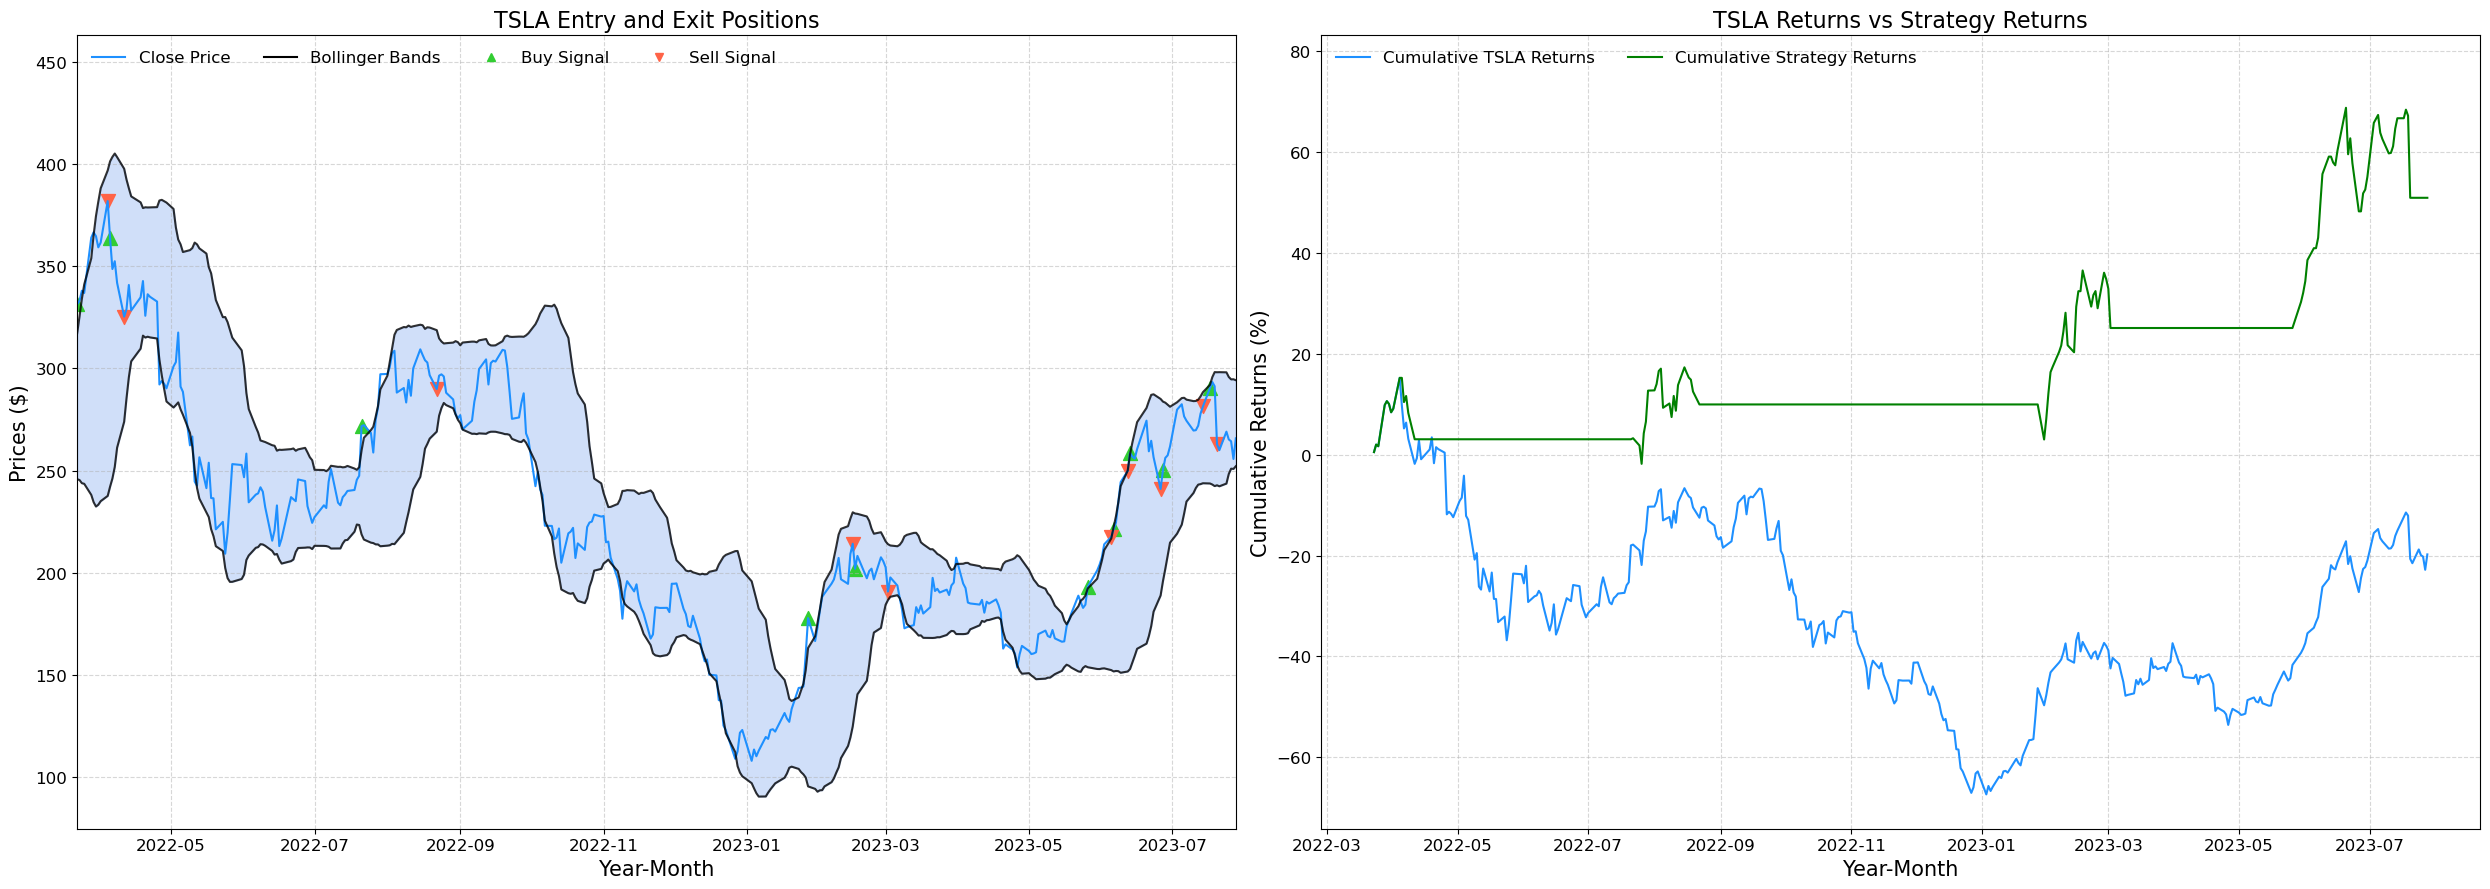

<h4 style="margin-bottom: 10px;">Breakout Strategy Metrics for TSLA:</h4>

<p style="margin-left: 20px;">Strategy Performance Against Underlying Stock: 70.73%<br>CAGR: 35.69%<br>Sharpe ratio: 1.24<br>Maximum Drawdown: -14.80%</p>

<h2 style="text-align:center;">NVDA</h2>

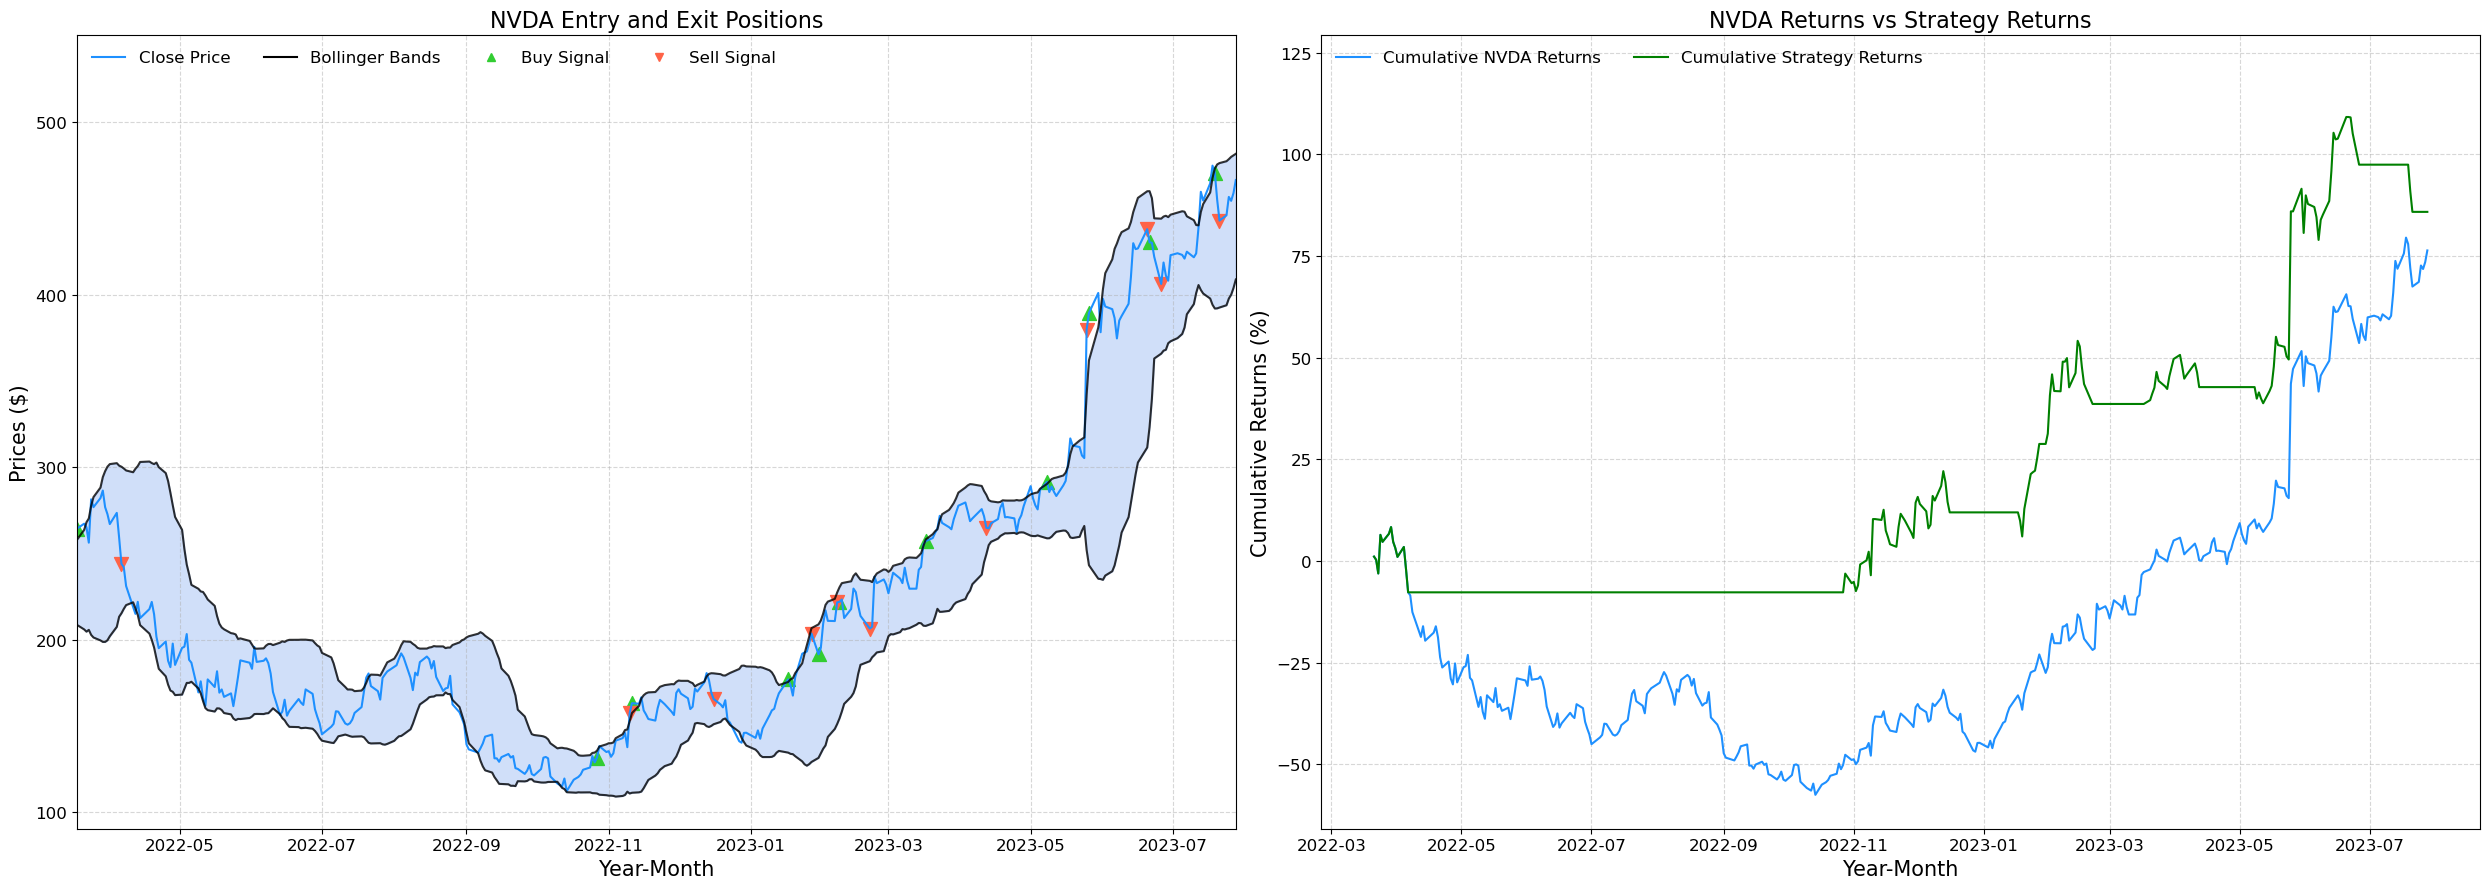

<h4 style="margin-bottom: 10px;">Breakout Strategy Metrics for NVDA:</h4>

<p style="margin-left: 20px;">Strategy Performance Against Underlying Stock: 9.49%<br>CAGR: 57.90%<br>Sharpe ratio: 1.39<br>Maximum Drawdown: -14.83%</p>

<h2 style="text-align:center;">AMZN</h2>

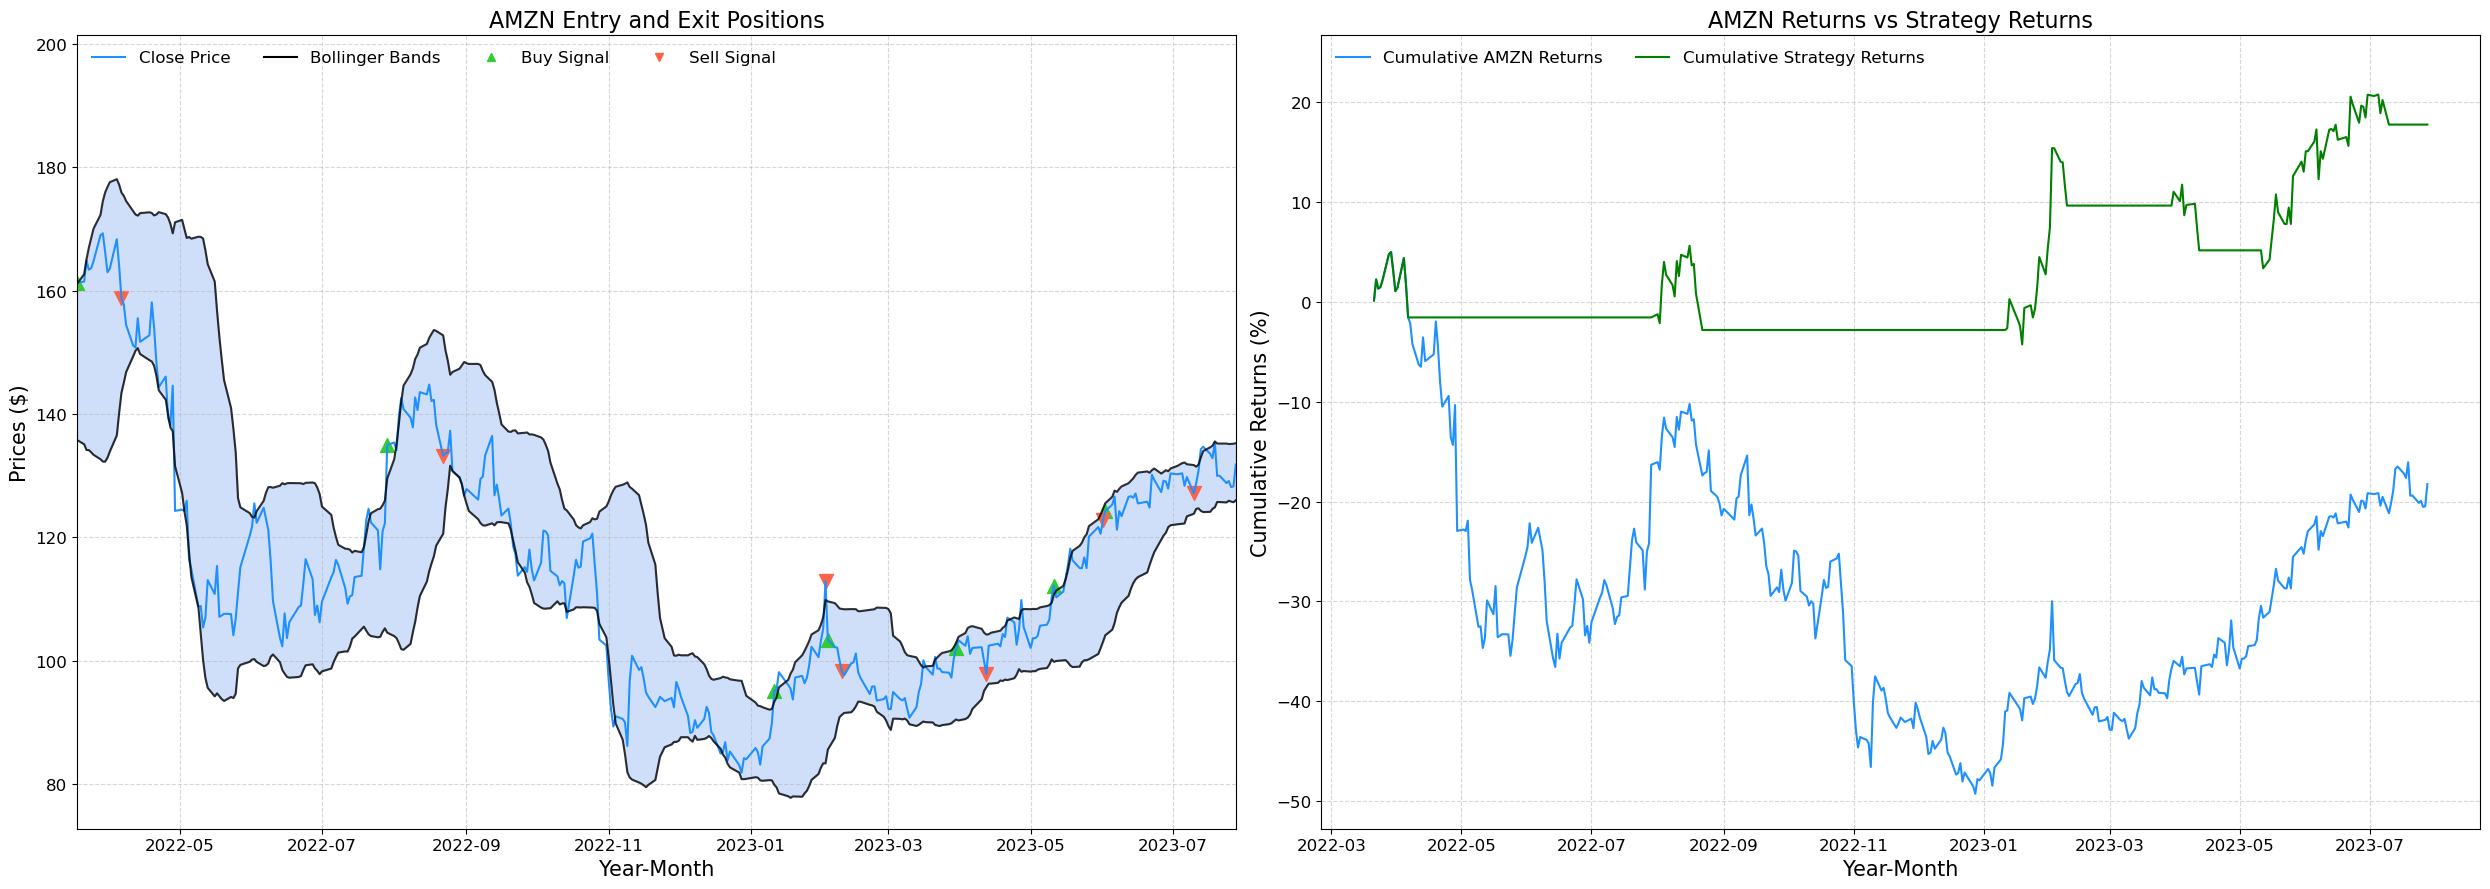

<h4 style="margin-bottom: 10px;">Breakout Strategy Metrics for AMZN:</h4>

<p style="margin-left: 20px;">Strategy Performance Against Underlying Stock: 36.01%<br>CAGR: 12.81%<br>Sharpe ratio: 0.80<br>Maximum Drawdown: -10.43%</p>

In [12]:
tsla_data, tsla_trades = performance(tsla)
nvda_data, nvda_trades = performance(nvda)
amzn_data, pypl_trades = performance(amzn)
plot(tsla_data, 'TSLA')
metrics(tsla_data, 'TSLA')
plot(nvda_data, 'NVDA')
metrics(nvda_data, 'NVDA')
plot(amzn_data, 'AMZN')
metrics(amzn_data, 'AMZN')
